# Analysis of EEG data

EEG data collected in a stop-go task ... 

### Overview
Preprocessing
- Filtering
- Remove bad channels
- Artefact removal (ICA)
- Epoching

## Preprocessing

In [1]:
%matplotlib inline

In [2]:
import mne
import pandas as pd
import os

### Load data

In [3]:
filepath = os.path.join("..", "data", "p1-raw.fif")
raw = mne.io.read_raw_fif(filepath)
raw.load_data()

Opening raw data file ..\data\p1-raw.fif...
    Range : 0 ... 1214579 =      0.000 ...  1214.579 secs
Ready.
Reading 0 ... 1214579  =      0.000 ...  1214.579 secs...


<Raw | p1-raw.fif, 32 x 1214580 (1214.6 s), ~296.6 MB, data loaded>

In [4]:
events, _ = mne.events_from_annotations(raw)

Non-RawBrainVision raw using branvision markers
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  1', 'Stimulus/S 10', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 20']


In [5]:
event_id = {'S20': 20, 'S11': 11, 'S10': 10}

C:\Users\Sara\AppData\Local\Temp/ipykernel_9776/329882116.py:1: RuntimeWarning: event 1 missing from event_id will be ignored
  mne.viz.plot_events(events[:50], sfreq=250, first_samp=raw.first_samp, event_id=event_id);
C:\Users\Sara\AppData\Local\Temp/ipykernel_9776/329882116.py:1: RuntimeWarning: event 12 missing from event_id will be ignored
  mne.viz.plot_events(events[:50], sfreq=250, first_samp=raw.first_samp, event_id=event_id);
C:\Users\Sara\AppData\Local\Temp/ipykernel_9776/329882116.py:1: RuntimeWarning: event 99999 missing from event_id will be ignored
  mne.viz.plot_events(events[:50], sfreq=250, first_samp=raw.first_samp, event_id=event_id);


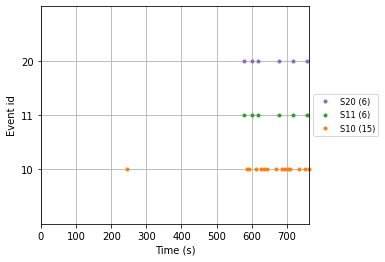

In [6]:
mne.viz.plot_events(events[:50], sfreq=250, first_samp=raw.first_samp, event_id=event_id);

### Filtering
- Highpass: 40Hz
- Lowpass: 0.1Hz

In [7]:
filtered = raw.copy().filter(l_freq=None, h_freq=40)
filtered = filtered.filter(l_freq=0.1, h_freq=None)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 sec)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 33001 samples (33.001 sec)



In [8]:
filtered.info

<Info | 12 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, T7, C3, Cz, ...
 chs: 32 EEG
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition
 dig: 35 items (3 Cardinal, 32 EEG)
 experimenter: mne_anonymize
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 lowpass: 40.0 Hz
 meas_date: 2000-01-01 00:00:00 UTC
 meas_id: 4 items (dict)
 nchan: 32
 projs: []
 sfreq: 1000.0 Hz
>

### Visual inspection
- Identify bad channels

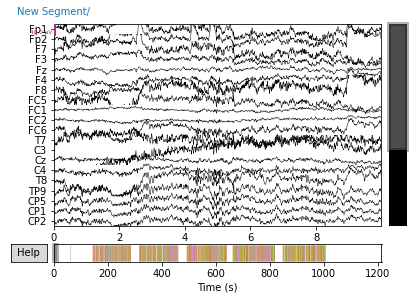

In [9]:
filtered.plot();

In [10]:
# remove bad channel C3
filtered.info['bads'] = ['C3']
filtered.info

<Info | 13 non-empty values
 bads: 1 items (C3)
 ch_names: Fp1, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, T7, C3, Cz, ...
 chs: 32 EEG
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition
 dig: 35 items (3 Cardinal, 32 EEG)
 experimenter: mne_anonymize
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 lowpass: 40.0 Hz
 meas_date: 2000-01-01 00:00:00 UTC
 meas_id: 4 items (dict)
 nchan: 32
 projs: []
 sfreq: 1000.0 Hz
>

### Artefact removal
- ICA

In [11]:
# set up and fit the ICA
# n_components untill 95% of variance is explained
ica = mne.preprocessing.ICA(n_components=0.95, random_state=97, max_iter=800)
ica.fit(filtered)

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by explained variance: 11 components
Fitting ICA took 14.4s.


<ICA | raw data decomposition, fit (fastica): 1214580 samples, 11 components, channels used: "eeg">

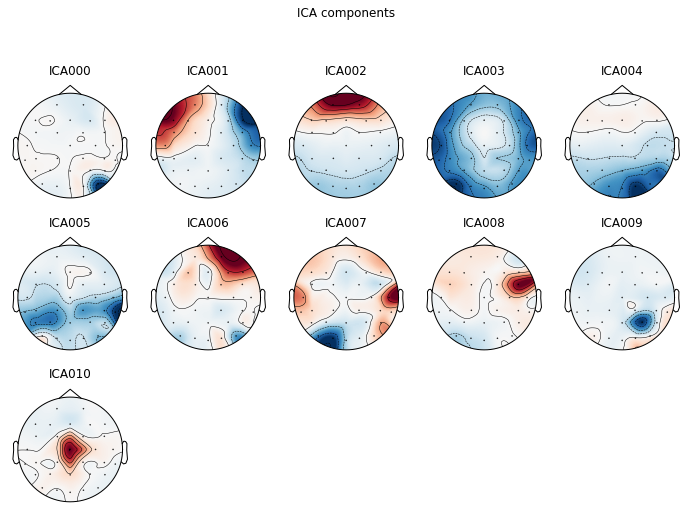

In [12]:
ica.plot_components();

Creating RawArray with float64 data, n_channels=11, n_times=1214580
    Range : 0 ... 1214579 =      0.000 ...  1214.579 secs
Ready.


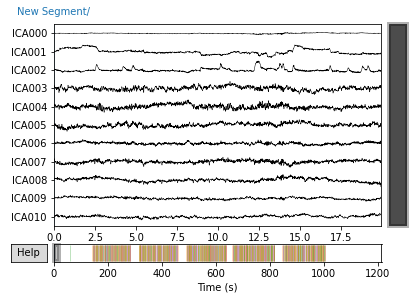

In [13]:
ica.plot_sources(filtered);

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
607 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
607 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
607 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


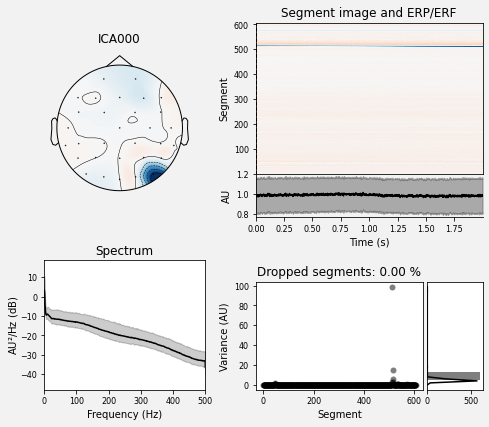

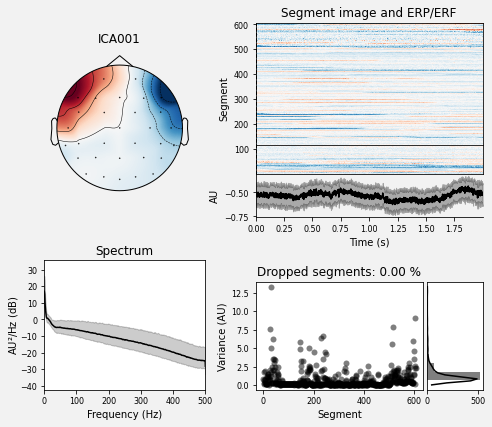

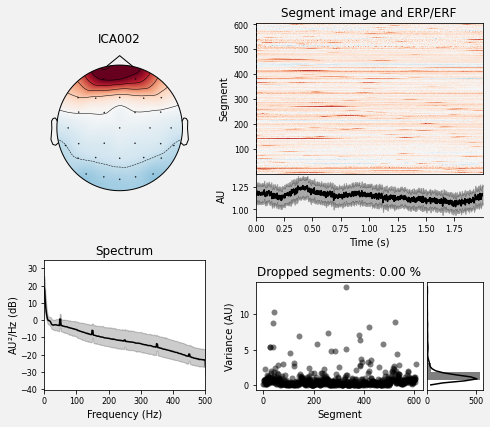

In [14]:
# 0: an artefact (muscle tension), 1: saccade, 2: eyeblink 
ica.exclude = [0, 1, 2] 
ica.plot_properties(raw, picks=ica.exclude);

In [15]:
# apply ICA
orig_filtered = filtered.copy() # saving a copy of the original data
filtered.load_data()
ica.apply(filtered)

Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 3 ICA components
    Projecting back using 31 PCA components


<Raw | p1-raw.fif, 32 x 1214580 (1214.6 s), ~296.6 MB, data loaded>

### Epoching
- tmin: 0.5, tmax: 1.55
- trigger value
- Reject from values
- Baseline: (None, 0)

In [16]:
events, _ = mne.events_from_annotations(filtered)

Non-RawBrainVision raw using branvision markers
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  1', 'Stimulus/S 10', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 20']


In [17]:
event_id = {'S20': 20, 'S11': 11, 'S10': 10}

C:\Users\Sara\AppData\Local\Temp/ipykernel_9776/1985523377.py:1: RuntimeWarning: event 1 missing from event_id will be ignored
  mne.viz.plot_events(events[:50], sfreq=250, first_samp=filtered.first_samp, event_id=event_id);
C:\Users\Sara\AppData\Local\Temp/ipykernel_9776/1985523377.py:1: RuntimeWarning: event 12 missing from event_id will be ignored
  mne.viz.plot_events(events[:50], sfreq=250, first_samp=filtered.first_samp, event_id=event_id);
C:\Users\Sara\AppData\Local\Temp/ipykernel_9776/1985523377.py:1: RuntimeWarning: event 99999 missing from event_id will be ignored
  mne.viz.plot_events(events[:50], sfreq=250, first_samp=filtered.first_samp, event_id=event_id);


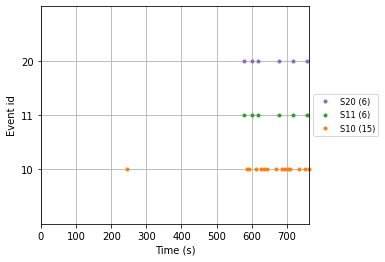

In [18]:
mne.viz.plot_events(events[:50], sfreq=250, first_samp=filtered.first_samp, event_id=event_id);

In [22]:
reject = dict(eeg=150e-6) # reject all epoch with signal over 150 µV
tmin, tmax = -0.5, 1.5

epochs = mne.Epochs(filtered, events, event_id, tmin, tmax,
                    baseline=(None, 0), reject=reject, preload=True)

Not setting metadata
Not setting metadata
439 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 439 events and 2001 original time points ...
    Rejecting  epoch based on EEG : ['P8', 'O2']
    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['TP10']
4 bad epochs dropped


In [21]:
epochs.info

<Info | 12 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, T7, Cz, C4, ...
 chs: 31 EEG
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition
 dig: 35 items (3 Cardinal, 32 EEG)
 experimenter: mne_anonymize
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 lowpass: 40.0 Hz
 meas_date: 2000-01-01 00:00:00 UTC
 meas_id: 4 items (dict)
 nchan: 31
 projs: []
 sfreq: 1000.0 Hz
>

In [32]:
epochs

Number of events,439
Events,S10: 240S11: 99S20: 100
Time range,0.500 – 1.550 sec
Baseline,off
